In [1]:
import os
import pandas as pd
import torch
from torchvision import models
from utils import DRDataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np

DESC = 'resnet'
if not os.path.exists(f'../results/{DESC}'):
    os.makedirs(f'../results/{DESC}')
    
#load labels
labels = pd.read_csv('../data/trainLabels.csv').head(100)

NUM_CLASSES = len(labels['level'].unique())
LABELS_MAP = ['0-No DR', '1-Mild', '2-Moderate', '3-Severe', '4-Proliferative DR']
BATCH_SIZE = 32

#load dataset
dataset = DRDataset(labels, '../data/train',
                         preproc=models.ResNet50_Weights.DEFAULT.transforms())

#Map labels with dataset images 
image_paths = labels_df['image'].values  # TODO check that csv has "image" or update with appropriate labeling
labels = labels_df['level'].values       # Target labels

# split into train/val/test using stratified sampling 
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    dataset, y, np.arange(len(image_ids)), test_size=0.3, stratify=y, random_state=42)

#train_data, val_data, test_data = torch.utils.data.random_split(dataset, [0.7, 0.1, 0.2])
# max_workers = os.cpu_count() // 2

# Apply SMOTE on the training labels (to balance classes)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(-1, 1), y_train)

# Convert back to original format
X_train_resampled = X_train_resampled.flatten()

# Create new DataFrame for resampled training data
train_labels_resampled = pd.DataFrame({'image': X_train_resampled, 'level': y_train_resampled})
test_labels = labels_df.iloc[test_idx] 

# Create dataset objects using the resampled labels
train_dataset = DRDataset(train_labels_resampled, '../data/train',
                          preproc=models.ResNet50_Weights.DEFAULT.transforms())
test_dataset = DRDataset(test_labels, '../data/train',
                         preproc=models.ResNet50_Weights.DEFAULT.transforms())

# Further split the test set into validation and test
val_size = int(0.5 * len(test_dataset))
test_size = len(test_dataset) - val_size
val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [val_size, test_size])

#Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

#dataset size checks
train_N = len(train_loader.dataset)
val_N = len(val_loader.dataset)
test_N = len(test_loader.dataset)

train_N, val_N, test_N

(70, 10, 20)

In [2]:
# load resnet
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# freeze weights
resnet.requires_grad_(False)
# adjust last layer for binary classification
resnet.fc = torch.nn.Linear(resnet.fc.in_features, NUM_CLASSES)
resnet.fc.requires_grad_(True)

# print model summary
from torchinfo import summary
summary(resnet, input_size=next(resnet.parameters()).size())

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 5]                   --
├─Conv2d: 1-1                            [64, 64, 4, 4]            (9,408)
├─BatchNorm2d: 1-2                       [64, 64, 4, 4]            (128)
├─ReLU: 1-3                              [64, 64, 4, 4]            --
├─MaxPool2d: 1-4                         [64, 64, 2, 2]            --
├─Sequential: 1-5                        [64, 256, 2, 2]           --
│    └─Bottleneck: 2-1                   [64, 256, 2, 2]           --
│    │    └─Conv2d: 3-1                  [64, 64, 2, 2]            (4,096)
│    │    └─BatchNorm2d: 3-2             [64, 64, 2, 2]            (128)
│    │    └─ReLU: 3-3                    [64, 64, 2, 2]            --
│    │    └─Conv2d: 3-4                  [64, 64, 2, 2]            (36,864)
│    │    └─BatchNorm2d: 3-5             [64, 64, 2, 2]            (128)
│    │    └─ReLU: 3-6                    [64, 64, 2, 2]     

In [3]:
# compile model
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss() # expects logits
optimizer = torch.optim.Adam(resnet.parameters())

# train
EPOCHS = 10
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_loss = torch.inf
for epoch in range(EPOCHS):
    # train
    resnet.train()
    running_loss = 0.0
    running_correct = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_correct += (torch.softmax(outputs, dim=1).argmax(dim=1) == labels).sum().item()

    # val
    resnet.eval()
    running_vloss = 0.0
    running_vcorrect = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = resnet(inputs)
            vloss = loss_fn(outputs, labels)
            running_vloss += vloss.item()
            running_vcorrect += (torch.softmax(outputs, dim=1).argmax(dim=1) == labels).sum().item()

    print(f"Epoch {epoch+1}/{EPOCHS}\t" +
          f"Train Loss: {running_loss/train_N:.4f} | Train Acc: {running_correct/train_N:.4f} | " +
          f"Val Loss: {running_vloss/val_N:.4f} | Val Acc: {running_vcorrect/val_N:.4f}")

    train_losses.append(running_loss/train_N)
    val_losses.append(running_vloss/val_N)
    train_accs.append(running_correct/train_N)
    val_accs.append(running_vcorrect/val_N)

    # save best model
    if running_vloss < best_val_loss:
        best_val_loss = running_vloss
        torch.save(resnet, f'../results/{DESC}/model.pth')

# evaluate
# load best model
resnet = torch.load(f'../results/{DESC}/model.pth', weights_only=False).to(DEVICE)
resnet.eval()
correct = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = resnet(inputs)
        correct += (torch.softmax(outputs, dim=1).argmax(dim=1) == labels).sum().item()
print()
print(f'Test Accuracy: {correct/test_N:.4f}')

Epoch 1/10	Train Loss: 0.0586 | Train Acc: 0.4286 | Val Loss: 0.1048 | Val Acc: 0.9000
Epoch 2/10	Train Loss: 0.0371 | Train Acc: 0.8000 | Val Loss: 0.0626 | Val Acc: 0.9000
Epoch 3/10	Train Loss: 0.0284 | Train Acc: 0.8000 | Val Loss: 0.0481 | Val Acc: 0.9000
Epoch 4/10	Train Loss: 0.0301 | Train Acc: 0.8000 | Val Loss: 0.0482 | Val Acc: 0.9000
Epoch 5/10	Train Loss: 0.0249 | Train Acc: 0.8000 | Val Loss: 0.0468 | Val Acc: 0.9000
Epoch 6/10	Train Loss: 0.0273 | Train Acc: 0.8000 | Val Loss: 0.0450 | Val Acc: 0.9000
Epoch 7/10	Train Loss: 0.0324 | Train Acc: 0.8000 | Val Loss: 0.0441 | Val Acc: 0.9000
Epoch 8/10	Train Loss: 0.0249 | Train Acc: 0.8000 | Val Loss: 0.0433 | Val Acc: 0.9000
Epoch 9/10	Train Loss: 0.0296 | Train Acc: 0.8000 | Val Loss: 0.0443 | Val Acc: 0.9000
Epoch 10/10	Train Loss: 0.0239 | Train Acc: 0.8000 | Val Loss: 0.0459 | Val Acc: 0.9000

Test Accuracy: 0.7500


In [4]:
# save datasets, optimizer state, and metrics to metadata file
torch.save({'train_data': train_data,
            'val_data': val_data,
            'test_data': test_data,
            'optimizer_state': optimizer.state_dict(),
            'metrics': pd.DataFrame({'train_loss': train_losses,
                                     'val_loss': val_losses,
                                     'train_acc': train_accs,
                                     'val_acc': val_accs})},
            
            f'../results/{DESC}/metadata.pt')

# training curves

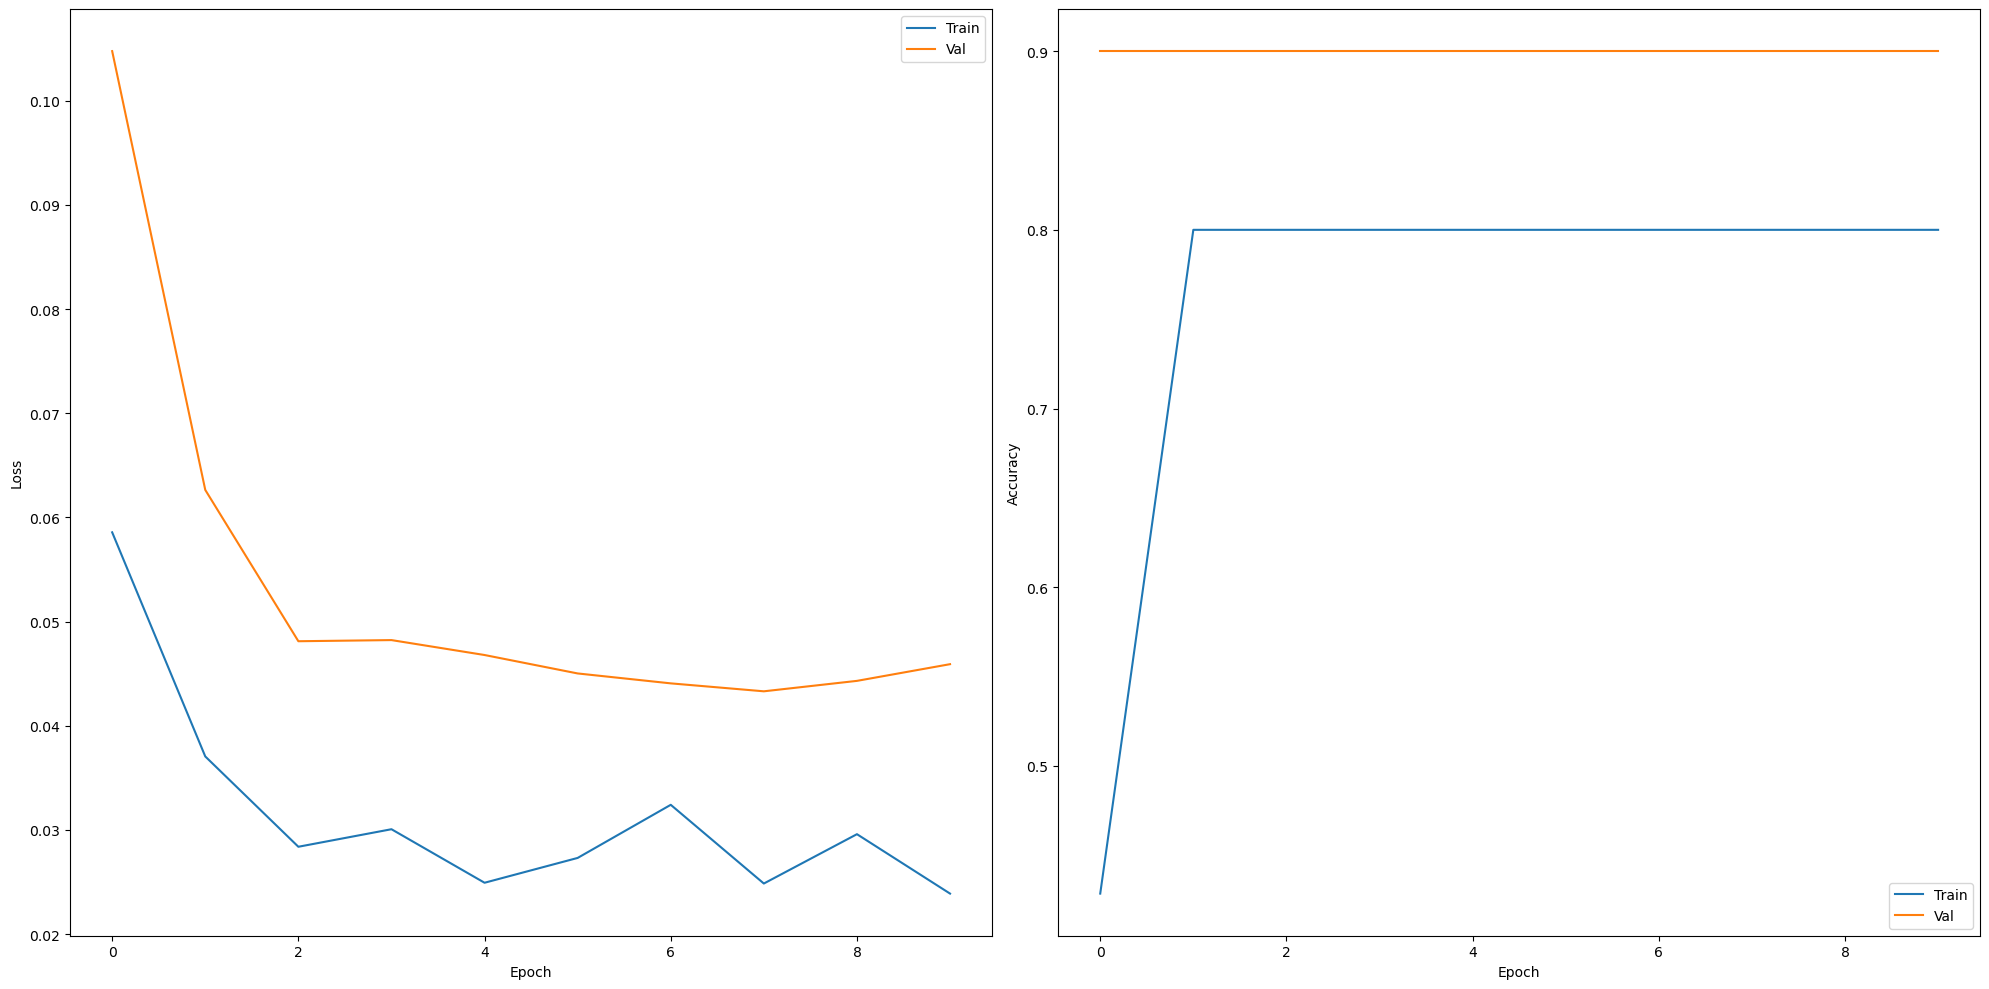

In [5]:
# plot training curves
import matplotlib.pyplot as plt

# losses
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig(f'../results/{DESC}/training_curves_{EPOCHS}epochs.png')
plt.show()

# confusion matrix

In [6]:
# test set results (~15min/1s if images are loaded/not loaded in memory)
resnet.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = resnet(inputs)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(torch.softmax(outputs, dim=1).argmax(dim=1).cpu().numpy())

                    precision    recall  f1-score   support

           0-No DR       0.75      1.00      0.86        15
            1-Mild       0.00      0.00      0.00         1
        2-Moderate       0.00      0.00      0.00         2
          3-Severe       0.00      0.00      0.00         1
4-Proliferative DR       0.00      0.00      0.00         1

          accuracy                           0.75        20
         macro avg       0.15      0.20      0.17        20
      weighted avg       0.56      0.75      0.64        20



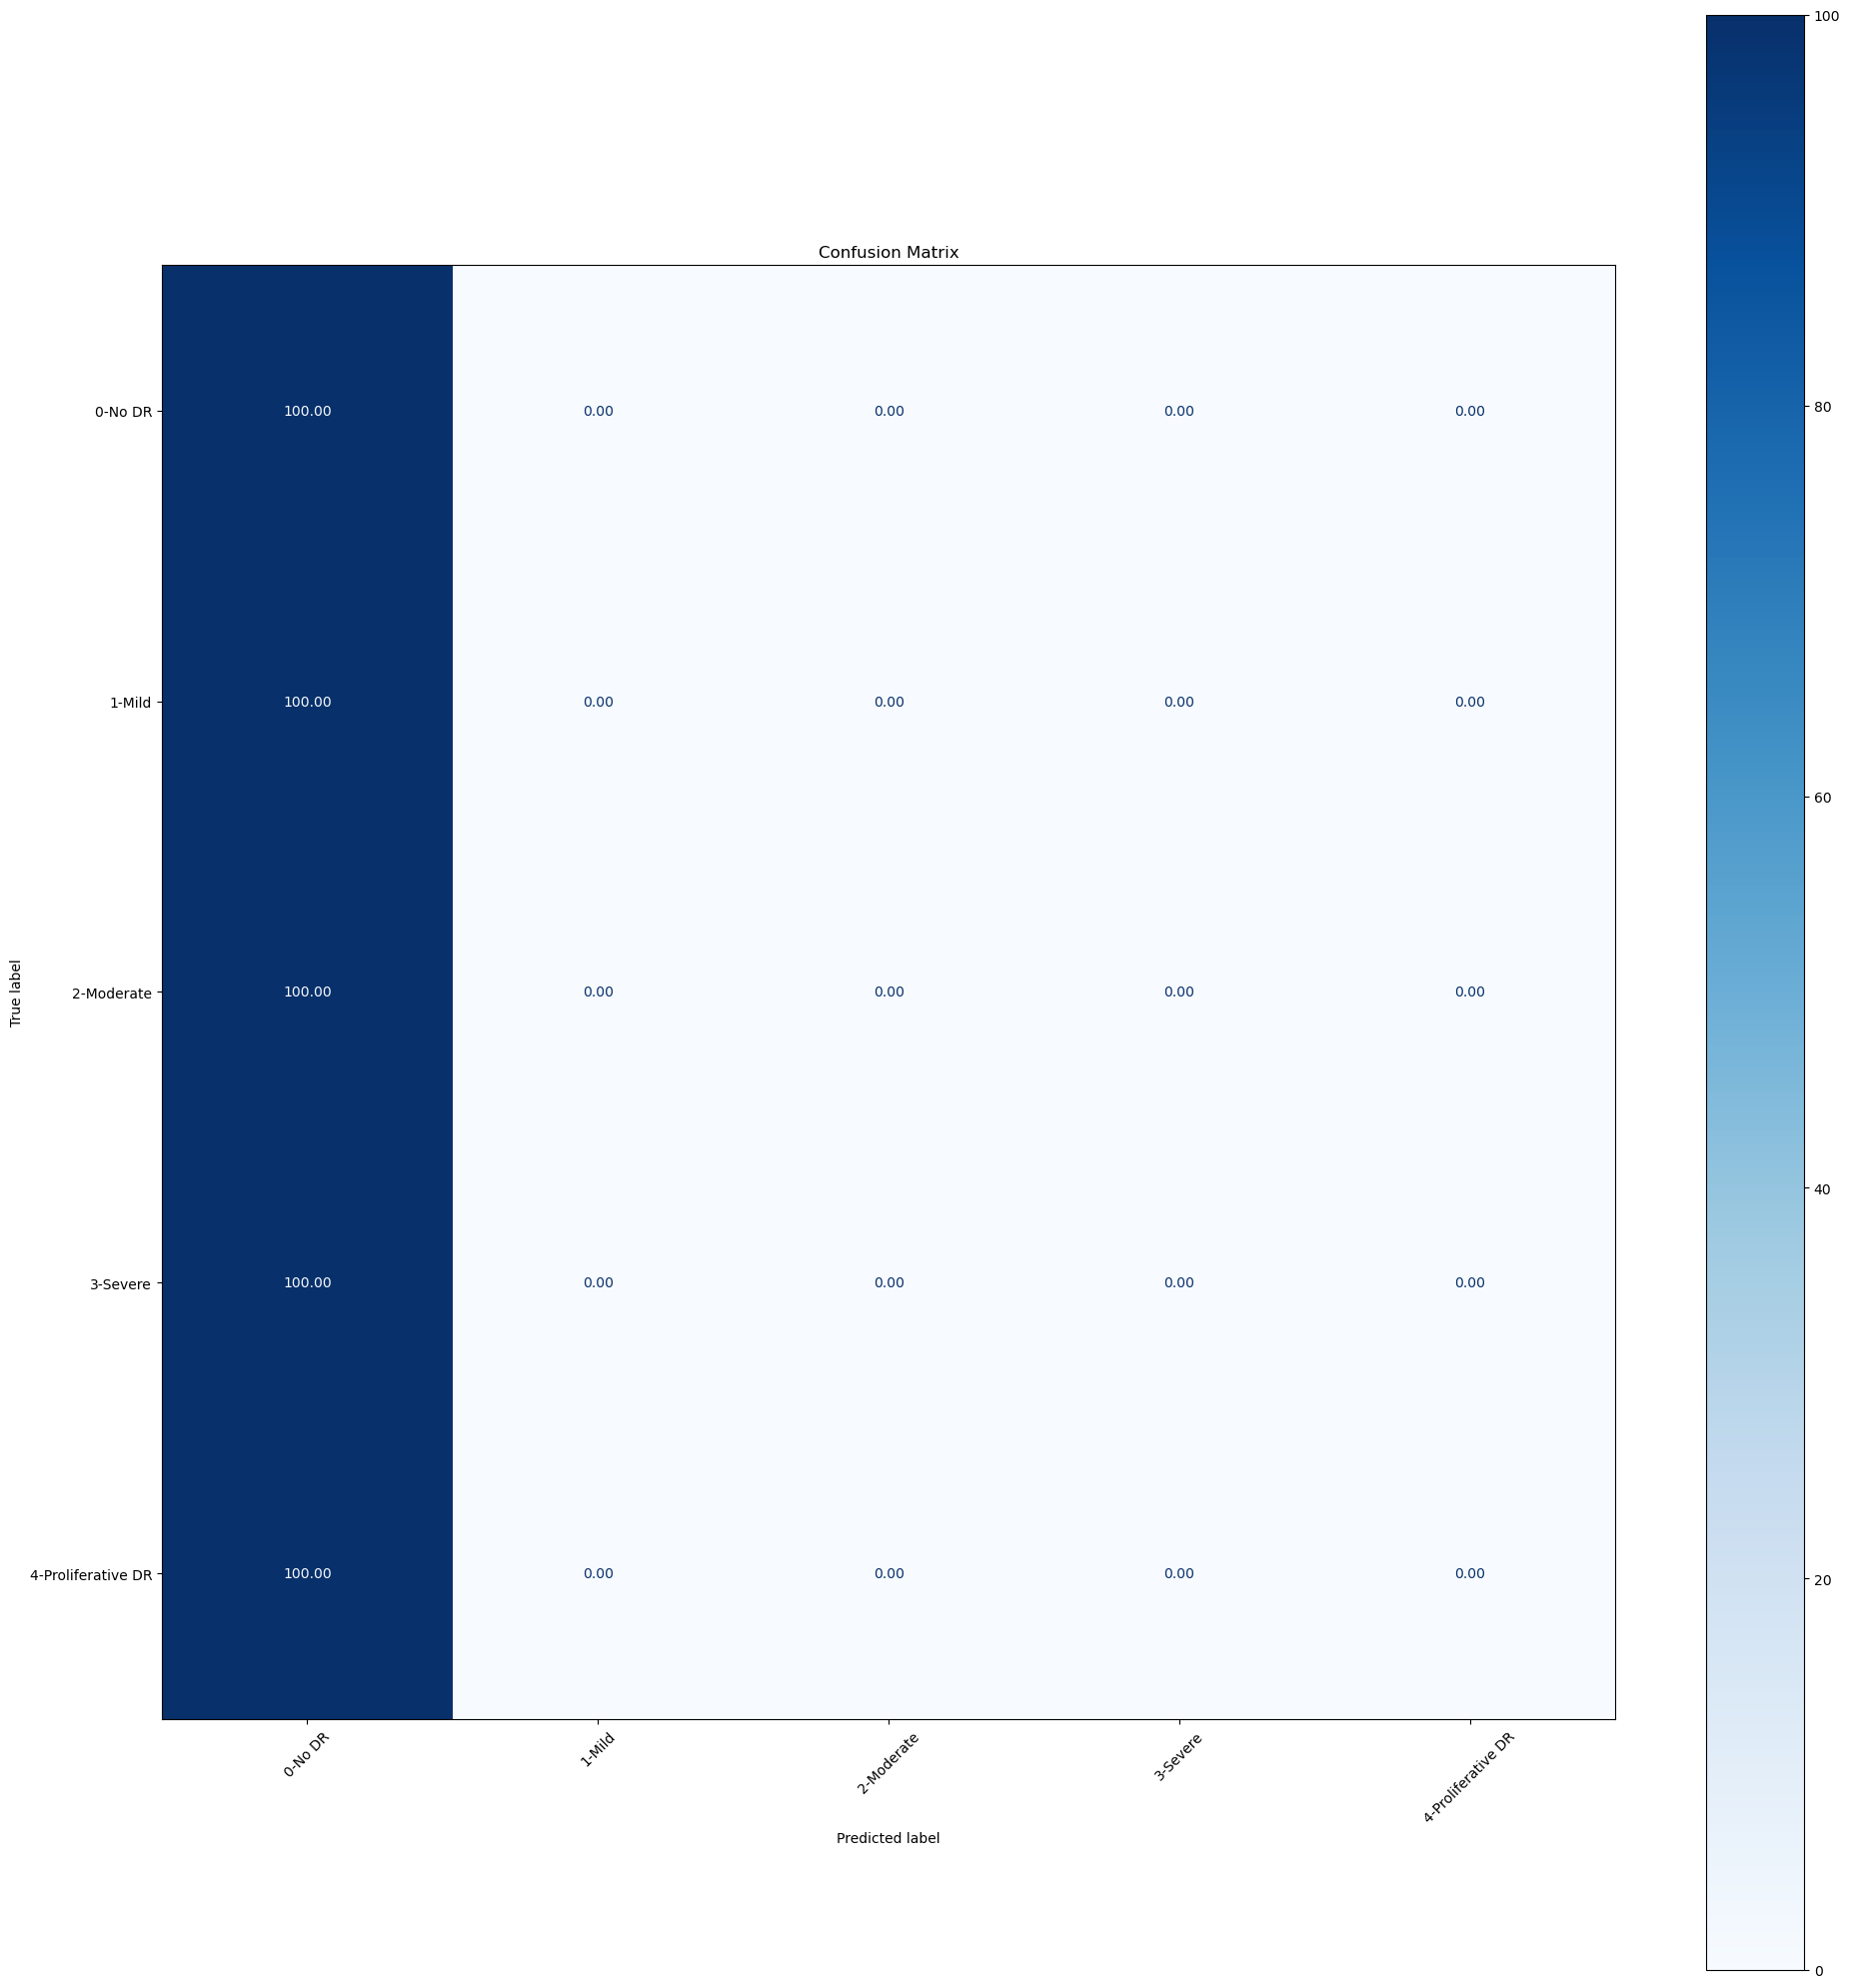

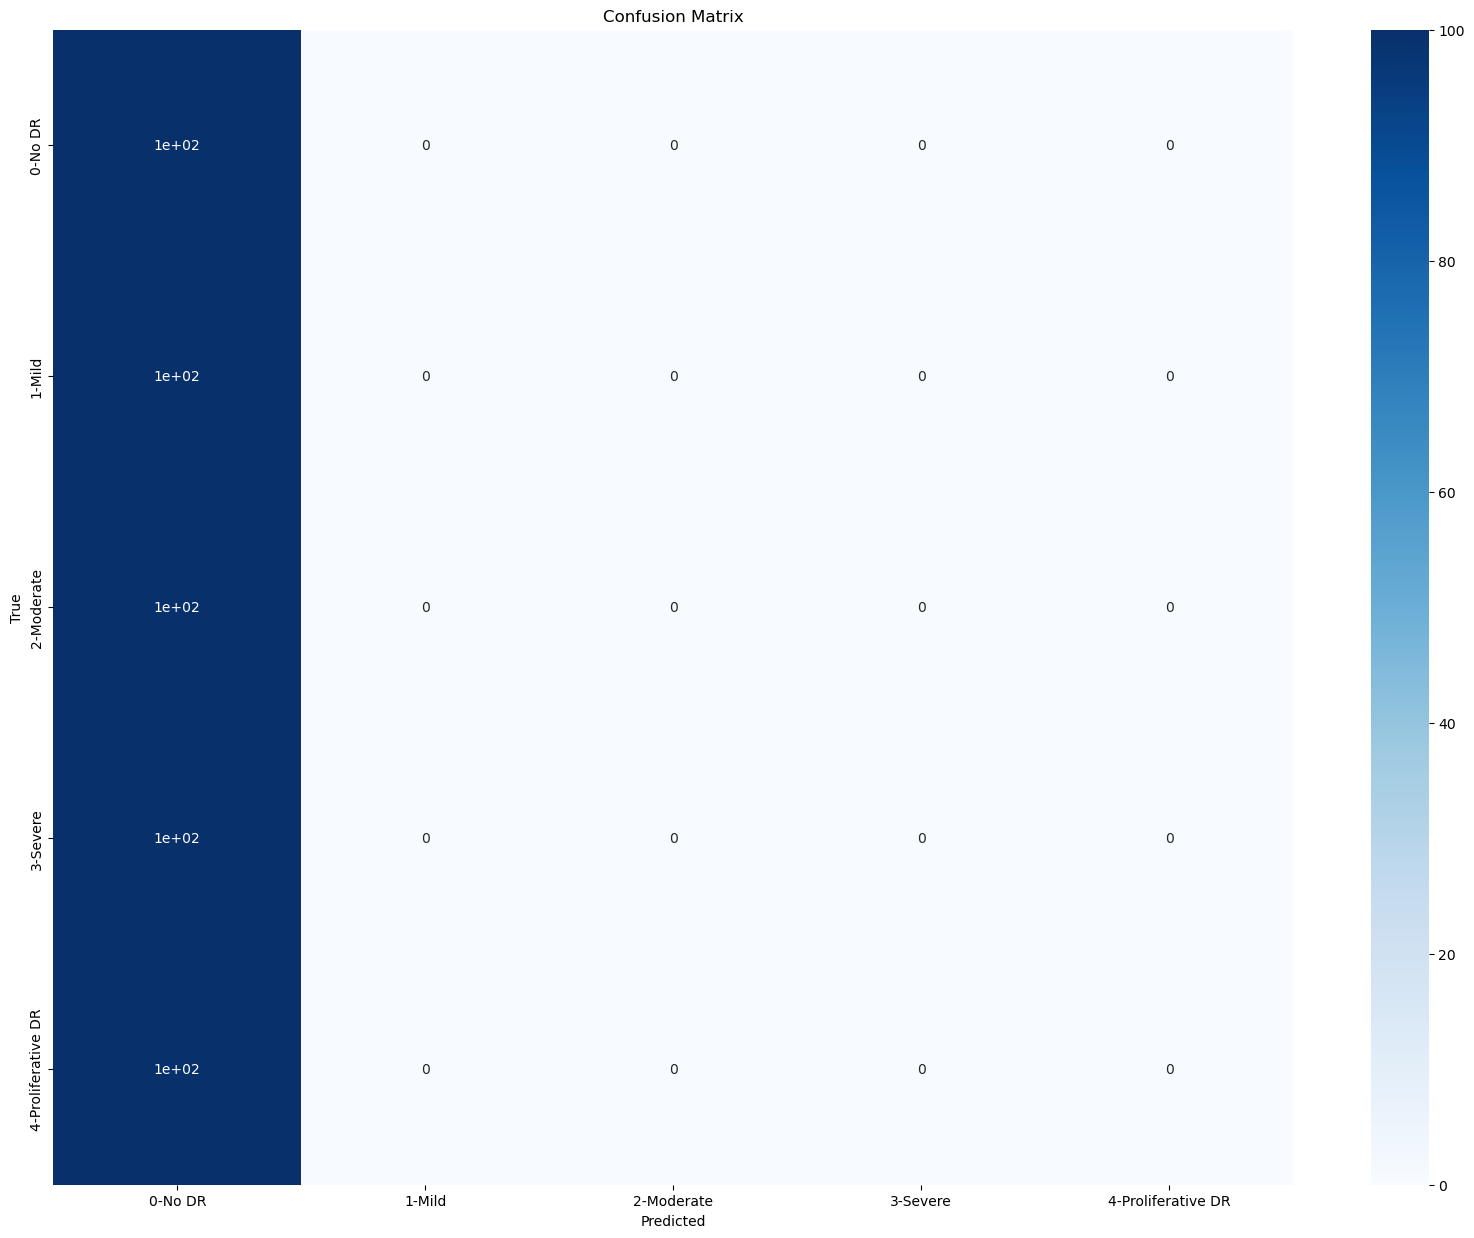

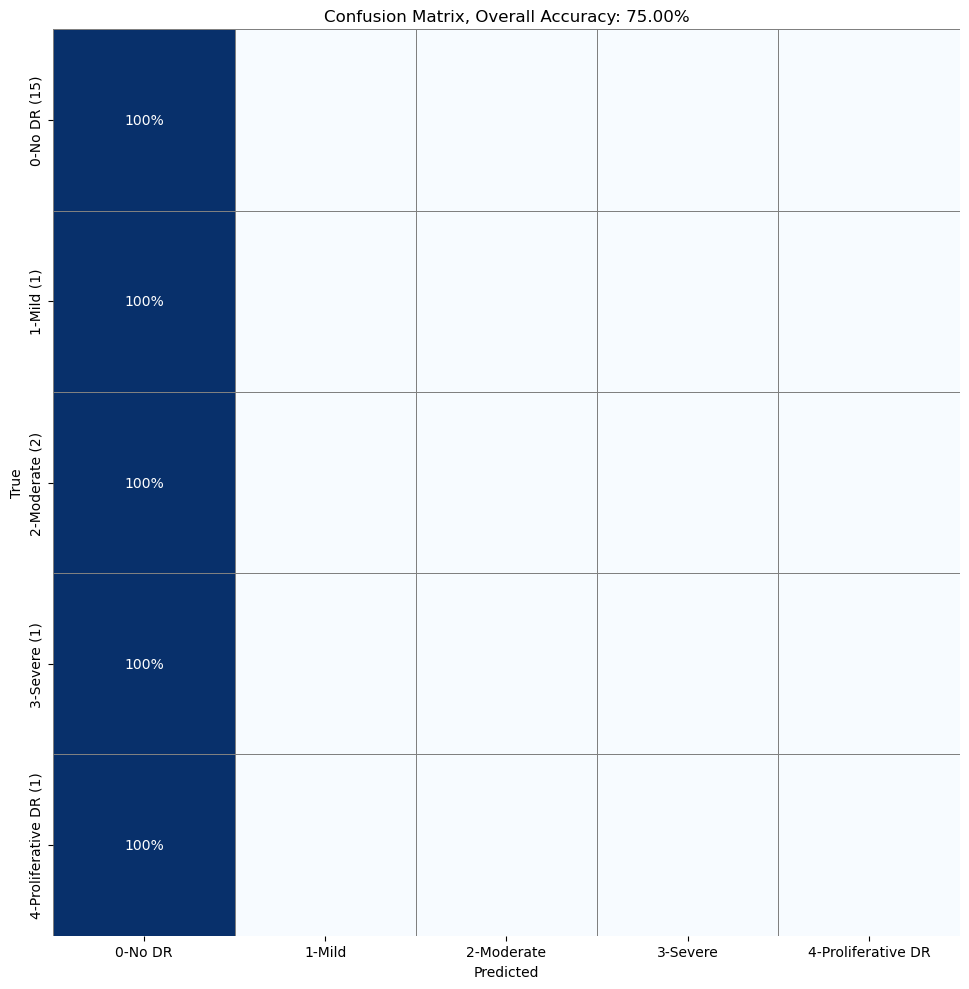

In [7]:
# TODO: clean this up

'''
CLASSIFICATION REPORT AND CONFUSIONMATRIXDISPLAY
'''
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
print(classification_report(y_true, y_pred, labels=range(NUM_CLASSES), target_names=LABELS_MAP, zero_division=0))

cm = 100*confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS_MAP)
# plot on large figure
fig, ax = plt.subplots(figsize=(20,20))
disp.plot(xticks_rotation = 45, values_format = '.2f', ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

'''
SIMPLE CONFUSION MATRIX
'''
# confusion matrix for test set
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# simple
cm = 100*confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES), normalize='true')
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, cmap='Blues',
            xticklabels=LABELS_MAP,
            yticklabels=LABELS_MAP)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

'''
CLEARER CONFUSION MATRIX (saved)
'''
# Compute normalized confusion matrix (row-wise normalization)
cm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES), normalize='true')

# Convert to integer percentages (whole numbers for clarity)
cm_percent = (cm * 100).astype(int)

# Get the number of true labels per class
true_counts = np.bincount(y_true, minlength=NUM_CLASSES)

# Create annotation labels: format as integer percentages, hide 0%
annot_labels = np.empty_like(cm_percent, dtype=object)
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        if cm_percent[i, j] > 0:
            annot_labels[i, j] = f"{cm_percent[i, j]}%"  # No decimals
        else:
            annot_labels[i, j] = ""

# Modify y-tick labels to include true label counts
class_labels = LABELS_MAP
yticklabels_with_counts = [f"{label} ({true_counts[i]})" for i, label in enumerate(class_labels)]

# Plot the heatmap in YOLO style
plt.figure(figsize=(12, 10))  # Adjust figure size for readability
sns.heatmap(cm_percent, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=yticklabels_with_counts,  # Updated y-tick labels
            linewidths=0.5, linecolor='gray', square=True, cbar=False)  # Clean grid layout

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix, Overall Accuracy: {100*correct/test_N:.2f}%')
plt.tight_layout()
plt.savefig(f'../results/{DESC}/confusion_matrix_{EPOCHS}epochs.png')
plt.show()